Using device: cpu

=== Training (Soft BC) ===
[Soft] Epoch      0 | PDE: 4.110e-01 | BC: 1.217e+00 | Total: 6.128e+01
[Soft] Epoch   1000 | PDE: 5.003e-03 | BC: 1.107e-08 | Total: 5.004e-03
[Soft] Epoch   2000 | PDE: 2.646e-03 | BC: 2.880e-09 | Total: 2.646e-03
[Soft] Epoch   3000 | PDE: 2.201e-03 | BC: 6.894e-09 | Total: 2.202e-03
[Soft] Epoch   4000 | PDE: 1.409e-03 | BC: 1.406e-08 | Total: 1.409e-03
[Soft] Epoch   5000 | PDE: 1.212e-03 | BC: 3.613e-08 | Total: 1.214e-03
[Soft] Epoch   6000 | PDE: 1.106e-03 | BC: 1.759e-06 | Total: 1.194e-03
[Soft] Epoch   7000 | PDE: 8.287e-04 | BC: 6.533e-10 | Total: 8.288e-04
[Soft] Epoch   8000 | PDE: 6.774e-04 | BC: 4.741e-07 | Total: 7.011e-04
[Soft] Epoch   9000 | PDE: 6.158e-04 | BC: 1.181e-10 | Total: 6.158e-04
[Soft] Epoch  10000 | PDE: 4.966e-04 | BC: 9.081e-09 | Total: 4.970e-04
[Soft] Epoch  11000 | PDE: 1.551e-04 | BC: 3.765e-04 | Total: 1.898e-02
[Soft] Epoch  12000 | PDE: 2.750e-05 | BC: 3.011e-10 | Total: 2.751e-05
[Soft] Epoch  1300

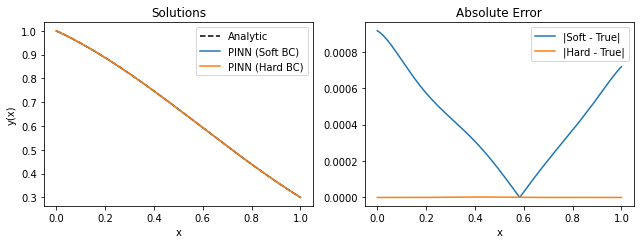

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Title: 1D ODE y'' + y = x with Non-Zero Dirichlet BCs (Soft vs Hard PINNs)

Problem:
    Solve y''(x) + y(x) = x,  x in (0,1)
    with y(0) = 1, y(1) = 0.3

Analytic solution (derived in the write-up):
    y*(x) = x + cos(x) - ((0.7 + cos(1)) / sin(1)) * sin(x)

We train two PINNs:
1) Soft boundary enforcement: loss = MSE(residual) + λ * MSE(BCs)
2) Hard boundary enforcement (lifting):
       y_theta(x) = A(x) + B(x) * N_theta(x),
   with A(0)=1, A(1)=0.3 and B(0)=B(1)=0, so BCs are satisfied exactly.
   Train only on the interior residual.

Implementation notes:
- Tanh activations and Xavier init for smooth derivatives and stable training.
- Randomly resample interior collocation points during training to reduce grid overfitting.
- For higher accuracy, increase hidden width/depth and/or epochs; optionally add an L-BFGS phase.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Reproducibility and device
# -------------------------
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------
# Analytic references
# -------------------
def y_star(x):
    """
    Analytic solution:
        y*(x) = x + cos(x) - ((0.7 + cos(1))/sin(1)) * sin(x)
    Accepts x as a torch tensor (N,1) on any device.
    """
    c = (0.7 + torch.cos(torch.tensor(1.0, device=x.device))) / torch.sin(torch.tensor(1.0, device=x.device))
    return x + torch.cos(x) - c * torch.sin(x)

# ---------------------
# Network architecture
# ---------------------
class Net1D(nn.Module):
    """
    Small fully-connected network N_theta(x).
    We'll use tanh activations for smooth derivatives.
    """
    def __init__(self, hidden=64, depth=4):
        super().__init__()
        layers = []
        layers.append(nn.Linear(1, hidden))
        layers.append(nn.Tanh())
        for _ in range(depth - 2):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden, 1))
        self.net = nn.Sequential(*layers)
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

# --------------------------
# Differential operators
# --------------------------
def second_derivative(y, x):
    """
    Compute y''(x) via autograd.
    y = model(x) must have create_graph=True in the grad path
    """
    dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x, grad_outputs=torch.ones_like(dy_dx), create_graph=True)[0]
    return d2y_dx2

# --------------------------
# Problem-specific functions
# --------------------------
def residual_from_model(model, x):
    """
    Residual R(x) = y''(x) + y(x) - x for a direct model y = model(x).
    """
    x.requires_grad_(True)
    y = model(x)
    y_xx = second_derivative(y, x)
    return y_xx + y - x

# Hard-BC trial solution components
def A_lifting(x):
    """
    Linear function satisfying the BCs exactly:
        A(0)=1, A(1)=0.3  ->  A(x) = 1 - 0.7 x
    """
    return 1.0 - 0.7 * x

def B_mask(x):
    """
    Vanishes at the boundary x=0 and x=1:
        B(0)=B(1)=0 -> choose B(x)=x(1-x)
    """
    return x * (1.0 - x)

def y_trial(model_N, x):
    """
    Hard-BC trial solution y_theta(x) = A(x) + B(x) * N_theta(x).
    """
    return A_lifting(x) + B_mask(x) * model_N(x)

def residual_hard(model_N, x):
    """
    Residual for the hard-BC trial solution: y'' + y - x.
    """
    x.requires_grad_(True)
    y = y_trial(model_N, x)
    y_xx = second_derivative(y, x)
    return y_xx + y - x

# ------------------------
# Training configurations
# ------------------------
class CFG:
    def __init__(self, n_int=128, lr=1e-3, epochs=15000, bc_weight=50.0, resample_every=200):
        self.n_int = n_int
        self.lr = lr
        self.epochs = epochs
        self.bc_weight = bc_weight     # used only for soft BCs
        self.resample_every = resample_every

# -----------------------
# Training: SOFT BOUNDARY
# -----------------------
def train_soft(cfg: CFG):
    """
    Train a PINN with soft boundary enforcement:
        loss = MSE(residual) + λ * ( (y(0)-1)^2 + (y(1)-0.3)^2 )
    """
    model = Net1D(hidden=64, depth=4).to(device)
    opt = optim.Adam(model.parameters(), lr=cfg.lr)

    # Two boundary points, fixed
    x0 = torch.tensor([[0.0]], device=device)
    x1 = torch.tensor([[1.0]], device=device)
    target0 = torch.tensor([[1.0]], device=device)
    target1 = torch.tensor([[0.3]], device=device)

    # Initial interior batch
    x_int = torch.rand(cfg.n_int, 1, device=device)

    for ep in range(cfg.epochs):
        opt.zero_grad()

        # PDE residual loss
        R = residual_from_model(model, x_int)
        loss_pde = torch.mean(R**2)

        # BC losses
        y0 = model(x0)
        y1 = model(x1)
        loss_bc = torch.mean((y0 - target0)**2) + torch.mean((y1 - target1)**2)

        loss = loss_pde + cfg.bc_weight * loss_bc
        loss.backward()
        opt.step()

        # Periodic resampling of interior points
        if (ep + 1) % cfg.resample_every == 0:
            x_int = torch.rand(cfg.n_int, 1, device=device)

        if ep % 1000 == 0:
            print(f"[Soft] Epoch {ep:6d} | PDE: {loss_pde.item():.3e} | BC: {loss_bc.item():.3e} | Total: {loss.item():.3e}")

    return model

# ----------------------
# Training: HARD BOUNDARY
# ----------------------
def train_hard(cfg: CFG):
    """
    Train a PINN with hard boundary enforcement (lifting).
    Only the residual term is minimized.
    """
    modelN = Net1D(hidden=64, depth=4).to(device)  # this learns N_theta
    opt = optim.Adam(modelN.parameters(), lr=cfg.lr)

    x_int = torch.rand(cfg.n_int, 1, device=device)

    for ep in range(cfg.epochs):
        opt.zero_grad()
        R = residual_hard(modelN, x_int)
        loss_pde = torch.mean(R**2)
        loss_pde.backward()
        opt.step()

        if (ep + 1) % cfg.resample_every == 0:
            x_int = torch.rand(cfg.n_int, 1, device=device)

        if ep % 1000 == 0:
            print(f"[Hard] Epoch {ep:6d} | PDE: {loss_pde.item():.3e}")

    return modelN

# ---------------
# Evaluation utils
# ---------------
def evaluate_models(model_soft, modelN_hard, n_test=400):
    xs = torch.linspace(0, 1, n_test, device=device).unsqueeze(1)
    with torch.no_grad():
        y_soft = model_soft(xs)
        y_hard = y_trial(modelN_hard, xs)
        y_true = y_star(xs)

    # Relative L2 errors
    def relL2(yhat, ytru):
        num = torch.linalg.norm((yhat - ytru).reshape(-1), ord=2)
        den = torch.linalg.norm(ytru.reshape(-1), ord=2)
        return (num/den).item()

    e_soft = relL2(y_soft, y_true)
    e_hard = relL2(y_hard, y_true)

    # Boundary errors
    with torch.no_grad():
        b_soft_0 = float(torch.abs(model_soft(torch.tensor([[0.0]], device=device)) - 1.0))
        b_soft_1 = float(torch.abs(model_soft(torch.tensor([[1.0]], device=device)) - 0.3))
        b_hard_0 = float(torch.abs(y_trial(modelN_hard, torch.tensor([[0.0]], device=device)) - 1.0))
        b_hard_1 = float(torch.abs(y_trial(modelN_hard, torch.tensor([[1.0]], device=device)) - 0.3))

    print("\n=== Test errors on a dense grid ===")
    print(f"Relative L2 (Soft BC): {e_soft:.3e} | Boundary abs errors: x=0 -> {b_soft_0:.2e}, x=1 -> {b_soft_1:.2e}")
    print(f"Relative L2 (Hard BC): {e_hard:.3e} | Boundary abs errors: x=0 -> {b_hard_0:.2e}, x=1 -> {b_hard_1:.2e}")

    # Plots
    xs_np = xs.cpu().numpy().flatten()
    y_true_np = y_true.cpu().numpy().flatten()
    y_soft_np = y_soft.cpu().numpy().flatten()
    y_hard_np = y_hard.cpu().numpy().flatten()

    plt.figure(figsize=(9, 3.5))

    plt.subplot(1,2,1)
    plt.plot(xs_np, y_true_np, 'k--', label='Analytic')
    plt.plot(xs_np, y_soft_np, label='PINN (Soft BC)')
    plt.plot(xs_np, y_hard_np, label='PINN (Hard BC)')
    plt.title("Solutions")
    plt.legend()
    plt.xlabel("x"); plt.ylabel("y(x)")

    plt.subplot(1,2,2)
    plt.plot(xs_np, np.abs(y_soft_np - y_true_np), label='|Soft - True|')
    plt.plot(xs_np, np.abs(y_hard_np - y_true_np), label='|Hard - True|')
    plt.title("Absolute Error")
    plt.legend()
    plt.xlabel("x")

    plt.tight_layout()
    plt.show()

# ----
# Main
# ----
def main():
    cfg_soft = CFG(n_int=128, lr=1e-3, epochs=15000, bc_weight=50.0, resample_every=200)
    cfg_hard = CFG(n_int=128, lr=1e-3, epochs=15000, bc_weight=0.0,  resample_every=200)

    print("\n=== Training (Soft BC) ===")
    model_soft = train_soft(cfg_soft)

    print("\n=== Training (Hard BC) ===")
    model_hardN = train_hard(cfg_hard)

    evaluate_models(model_soft, model_hardN, n_test=400)

if __name__ == "__main__":
    main()
